# Performance computing in python

## Some background - CPython

CPython is the reference implementation of the Python programming language.

### Key Points

1. **Written in the `C` programming language**: Hence the name "CPython"
2. **Most widely used**: It's the standard Python implementation
3. **Compiler and Interpreter**: 
   - Compiles Python code to bytecode
   - Interprets the bytecode
4. **Comprehensive**: Includes the Python standard library and core language features
5. **Open-source**: Serves as a blueprint for other Python implementations

CPython is the foundation upon which most Python development is built.

### CPython: Pros and Cons

#### Pros

1. Large ecosystem
   - Most Python libraries and frameworks are built for CPython
1. Stability and reliability
   - Well-tested and mature
1. Regular updates
   - Frequent bug fixes and performance improvements
1. C extensions support
   - Allows for performance-critical parts to be written in C
1. Memory management
   - Built-in garbage collection

#### Cons

1. Global Interpreter Lock (GIL)
   - Limits true multi-threading for CPU-bound tasks
1. **Performance**
   - Generally slower than compiled languages for certain tasks
1. Memory usage
   - Can be higher compared to some other implementations
1. Startup time
   - Can be slow, especially for small scripts
1. Platform dependence
   - Binaries are not cross-platform

So, if we want CPython but faster, what can we do?

## Simple optimizations

In [76]:
# Demonstrate pure Python optimization techniques

# Example 1: Local vs. global variable lookup
import math

def slow_hypot(x, y, n):
    """Calculate hypotenuse n times using global math.sqrt"""
    results = []
    for i in range(n):
        results.append(math.sqrt(x*x + y*y))
    return results

def fast_hypot(x, y, n):
    """Calculate hypotenuse n times using local sqrt reference"""
    sqrt = math.sqrt  # Local reference
    results = []
    for i in range(n):
        results.append(sqrt(x*x + y*y))
    return results


In [77]:
n = 1000000
%timeit slow_hypot(3.0, 4.0, n)
%timeit fast_hypot(3.0, 4.0, n)

145 ms ± 2.29 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
133 ms ± 1.11 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [78]:
# Example 2: List building - append vs. comprehension
def build_list_append(n):
    """Build a list using append method"""
    result = []
    for i in range(n):
        result.append(i*i)
    return result

def build_list_comprehension(n):
    """Build a list using list comprehension"""
    return [i*i for i in range(n)]

def build_list_preallocated(n):
    """Build a list using pre-allocation"""
    result = [0] * n
    for i in range(n):
        result[i] = i*i
    return result


In [82]:
# Compare performance
%timeit build_list_append(n)
%timeit build_list_comprehension(n)
%timeit build_list_preallocated(n)


86.6 ms ± 1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
76.2 ms ± 2.27 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
79.9 ms ± 1.14 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [80]:

# Example 3: Function calls vs. inlining
def slow_sum_squares(numbers):
    """Sum of squares with function calls"""
    def square(x):
        return x*x
    
    total = 0
    for num in numbers:
        total += square(num)
    return total

def fast_sum_squares(numbers):
    """Sum of squares with inlined calculation"""
    total = 0
    for num in numbers:
        total += num*num
    return total


In [81]:
numbers = list(range(n))
%timeit slow_sum_squares(numbers)
%timeit fast_sum_squares(numbers)

110 ms ± 1.88 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
75.8 ms ± 1.53 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Choosing the right data-strucutres

In [84]:
# Demonstrate performance impact of data structure selection

import random

# Generate test data
n = 100000
random_numbers = [random.randint(0, n*10) for _ in range(n)]

# Example 1: List vs. Set for lookups
def list_lookups(values, lookups):
    """Perform lookups in a list"""
    count = 0
    for lookup in lookups:
        if lookup in values:
            count += 1
    return count

def set_lookups(values, lookups):
    """Perform lookups in a set"""
    values_set = set(values)
    count = 0
    for lookup in lookups:
        if lookup in values_set:
            count += 1
    return count

# Generate lookup data
lookup_values = [random.randint(0, n*10) for _ in range(1000)]

# Compare performance
%timeit list_lookups(random_numbers, lookup_values)
%timeit set_lookups(random_numbers, lookup_values)


1.16 s ± 19 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
8.49 ms ± 304 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [85]:
# Example 2: Dictionary vs. List for frequent access by key
def build_and_access_list(keys, values, access_keys):
    """Build a list and access it by finding keys"""
    data = list(zip(keys, values))
    results = []
    for key in access_keys:
        for k, v in data:
            if k == key:
                results.append(v)
                break
    return results

def build_and_access_dict(keys, values, access_keys):
    """Build a dictionary and access it directly by keys"""
    data = dict(zip(keys, values))
    results = []
    for key in access_keys:
        results.append(data.get(key))
    return results


# Generate key-value data
keys = [f"key_{i}" for i in range(n)]
values = list(range(n))
access_keys = [f"key_{random.randint(0, n-1)}" for _ in range(1000)]



%timeit build_and_access_list(keys, values, access_keys)
%timeit build_and_access_dict(keys, values, access_keys)

1.64 s ± 13.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
19.3 ms ± 449 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Cython

[Cython](http://docs.cython.org/src/userguide/numpy_tutorial.html#cython-at-a-glance) is a compiler that converts Python-like code to C code, but it's not a direct Python-to-C translator. Instead, it:

- Compiles to native machine code while still using the Python runtime environment
- Adds syntax for embedding faster C-like code

### Key Consequences

1. **Speed Improvements**
   - Minimal for typical numerical programs
   - Significant for for-loop-style programs with added type information

2. **Easier C Integration**
   - Simplifies wrapping C libraries
   - Allows calling C code as easily as Python code

### Limitations

- Not all Python constructs are supported (e.g., inner functions, generator functions)
- Goal is to eventually support all Python code

### Example - Mandelbrot fractal

In [65]:
import numpy as np

def mandelbrot(m, size, iterations):    
    for i in range(size):
        for j in range(size):
            c = -2 + 3.0 / size * j + 1j * (1.5 - 3.0 / size * i)
            z = 0
            for n in range(iterations):
                if np.abs(z) <= 10:
                    z = z * z + c
                    m[i, j] = n
                else:
                    break

In [ ]:
size = 100
iterations = 100
m = np.zeros((size, size), dtype=np.int64)

In [3]:
%timeit mandelbrot(m, size, iterations)

1.29 s ± 18.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [44]:
from matplotlib import pyplot as plt

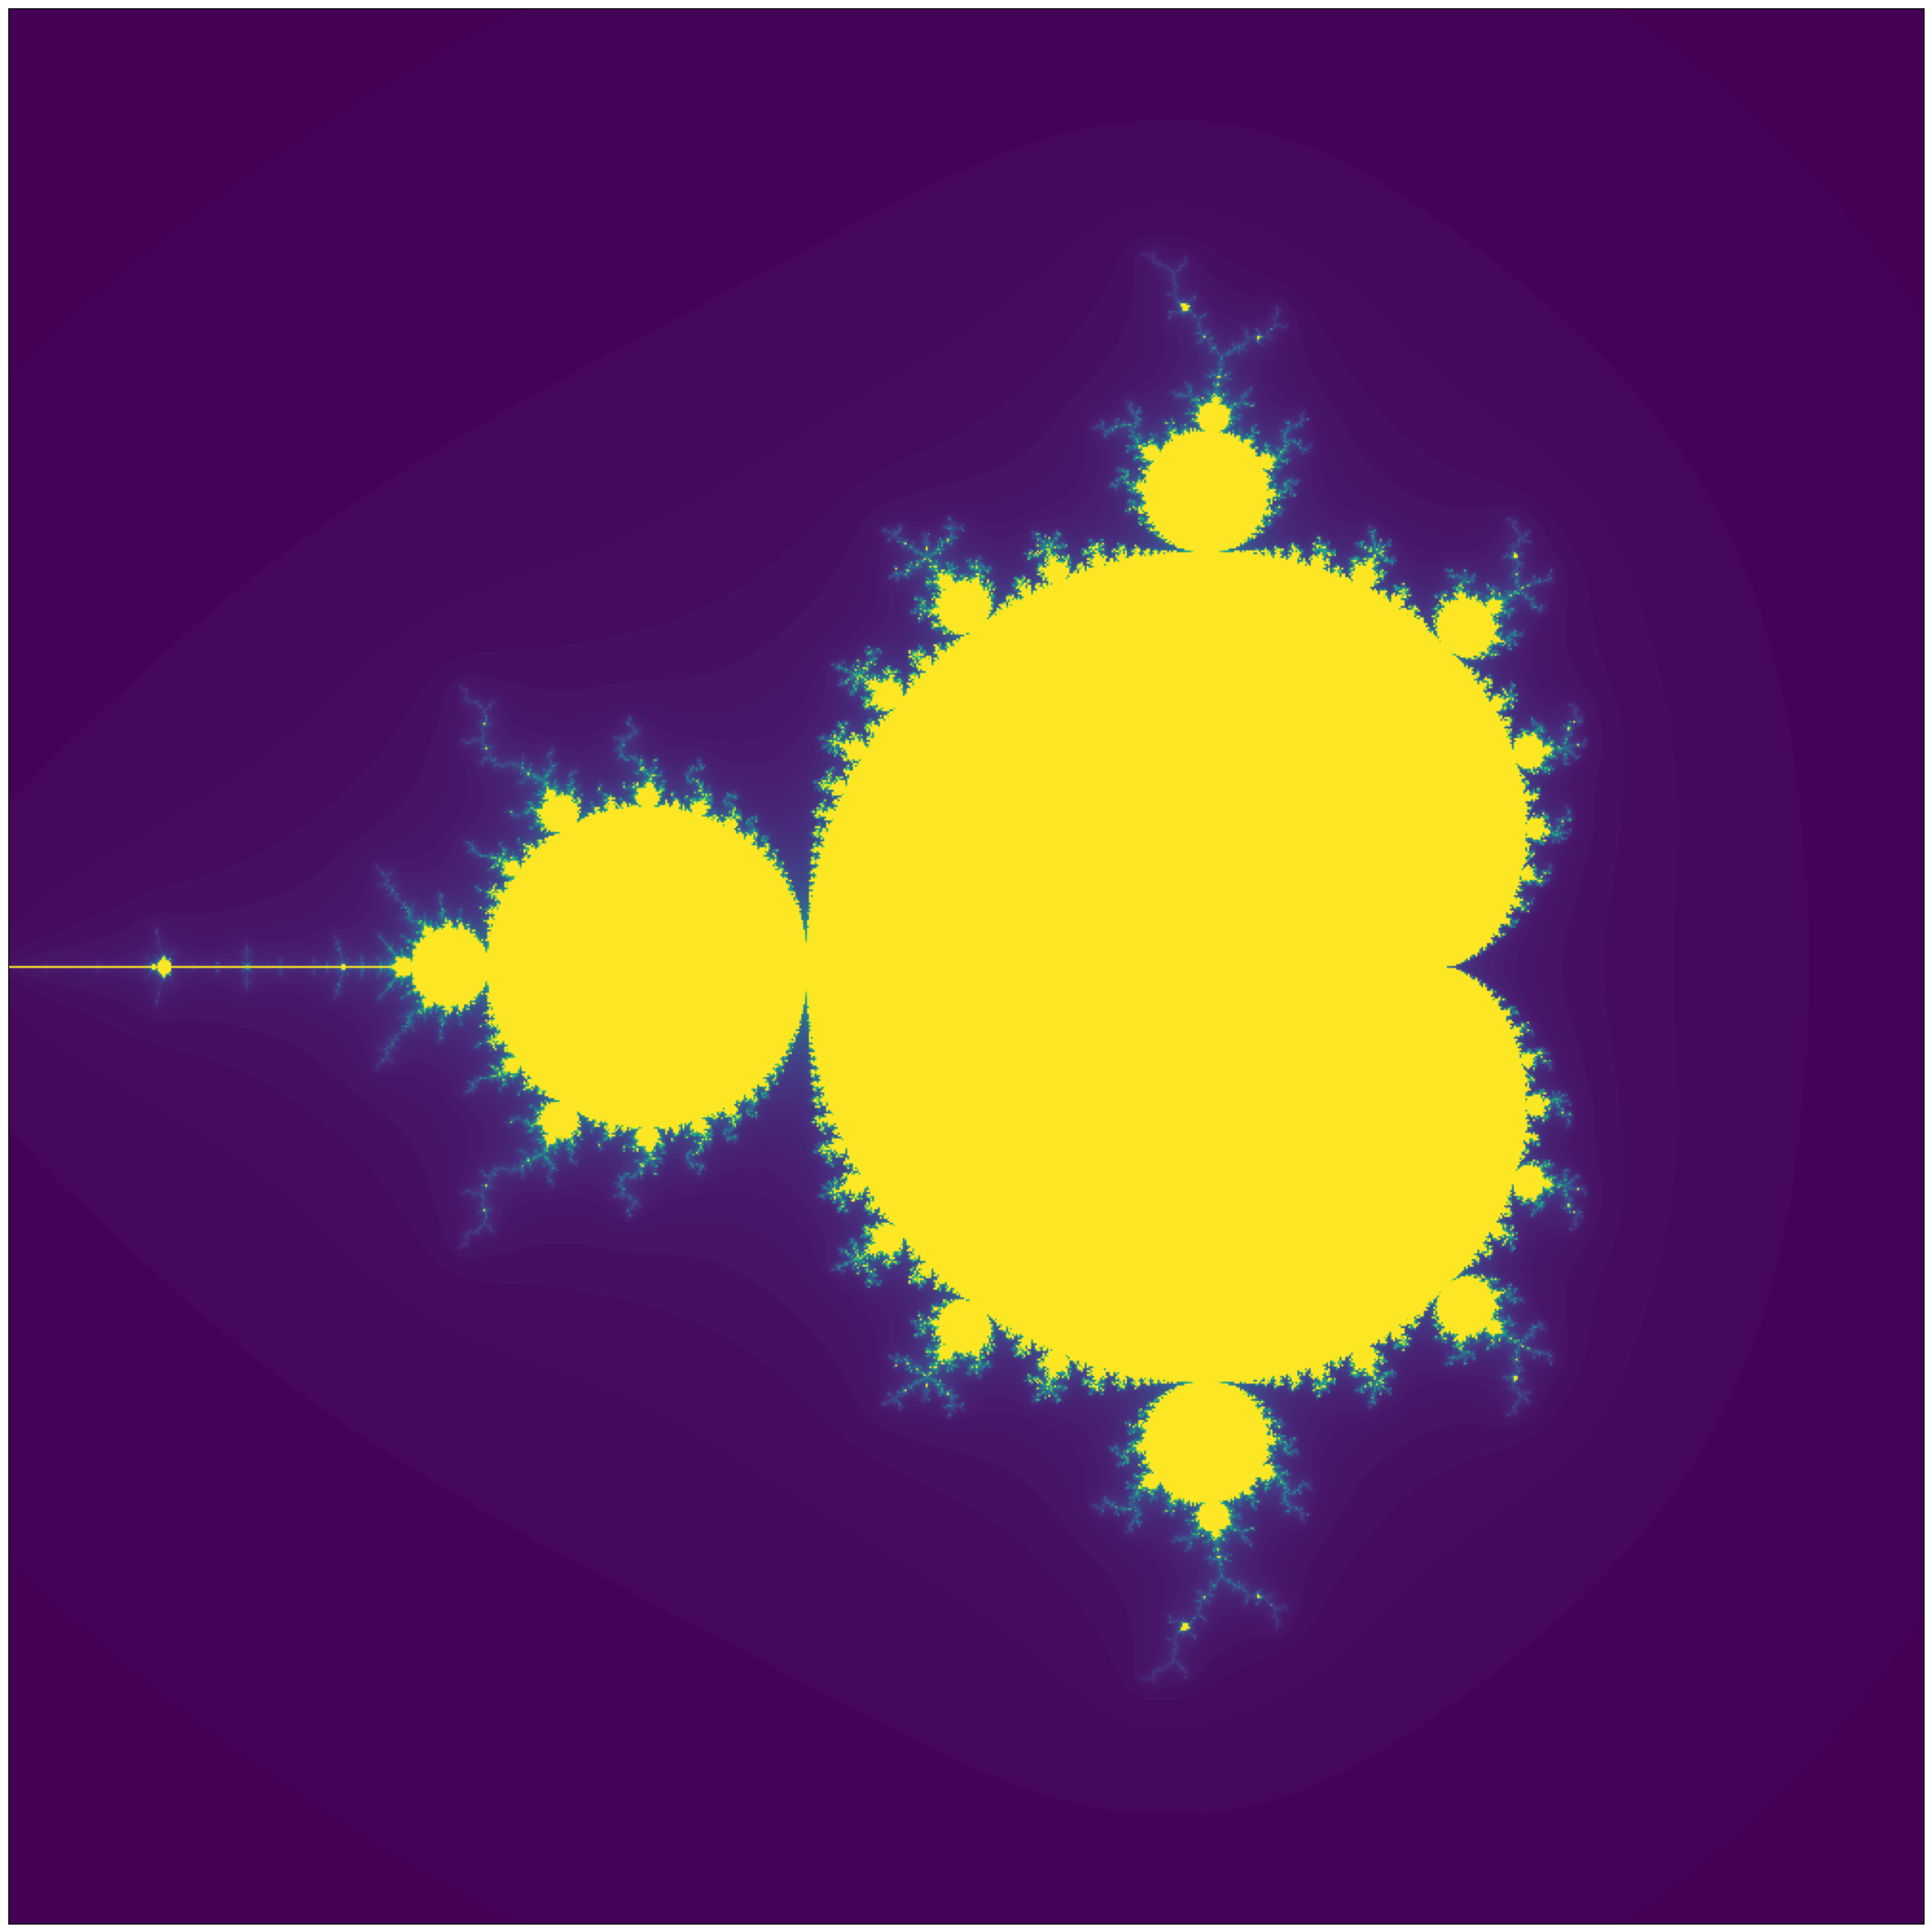

In [69]:
mandelbrot(m, size, iterations)
plt.figure(figsize=(30, 30))
plt.imshow(m, cmap='viridis')
plt.xticks([])
plt.yticks([]);

## Numpy

In [86]:
import numpy as np
# Demonstrating NumPy vectorization benefits

def python_distance(points1, points2):
    """Calculate Euclidean distance between sets of points using Python loops"""
    n = len(points1)
    result = np.zeros(n)
    for i in range(n):
        x1, y1 = points1[i]
        x2, y2 = points2[i]
        result[i] = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return result

def numpy_distance(points1, points2):
    """Calculate Euclidean distance between sets of points using NumPy vectorization"""
    return np.sqrt(np.sum((points2 - points1)**2, axis=1))

# Generate random points for testing
n = 1000000
points1 = np.random.random((n, 2))
points2 = np.random.random((n, 2))

# Compare performance
%timeit python_distance(points1, points2)
%timeit numpy_distance(points1, points2)

4.05 s ± 155 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
23.8 ms ± 311 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Numba

[Numba](http://numba.pydata.org) is a just-in-time (JIT) compiler for Python, focusing on numerical and scientific computing.

### Key Features

1. **Performance**
   - Compiles Python code to native machine instructions
   - Achieves performance similar to C, C++, and Fortran

2. **Ease of Use**
   - Works with Python code directly
   - Requires minimal annotations

3. **JIT Compilation**
   - Combines speed of compiled code with flexibility of interpretation
   - Incurs some overhead for compilation
   - More on [JIT compilation](https://en.wikipedia.org/wiki/Just-in-time_compilation)

4. **Multithreading Support**
   - Allows release of the Global Interpreter Lock (GIL)
   - Enables true multithreading for CPU-bound tasks

5. **Automatic Parallelization**
   - Can parallelize code automatically in some cases

Numba is particularly effective for array-oriented and math-heavy Python code, offering significant speed improvements without changing languages or Python interpreters.

In [70]:
import numba
print('Numba', numba.__version__)

Numba 0.61.2


In [87]:
@numba.jit()
def numandelbrot(m, size, iterations):    
    for i in range(size):
        for j in range(size):
            c = -2 + 3.0 / size * j + 1j * (1.5 - 3.0 / size * i)
            z = 0
            for n in range(iterations):
                if np.abs(z) <= 10:
                    z = z * z + c
                    m[i, j] = n
                else:
                    break
numandelbrot(m, size, iterations); # run once for jit to work

In [88]:
size = 100
iterations = 100
m = np.zeros((size, size), dtype=np.int64)

# %timeit mandelbrot(m, size, iterations) # too slow
%timeit mandelbrot(m, size, iterations)
%timeit numandelbrot(m, size, iterations)

331 ms ± 13.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.8 ms ± 86.9 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Exercise - Numba

Consider the following NumPy function which calculates the mean squared error of two arrays:

In [95]:
n = 100000
x = np.random.random(n)
y = np.random.random(n)

In [96]:
def mse_np(x, y):
    return ((x - y)**2).mean()

mse_np(x, y)

0.16571812243221626

In [ ]:
def mse_py(x, y):
    pass

def mse_nm(x, y):
    pass

In [ ]:
%timeit mse_py(x, y)
%timeit mse_np(x, y)
%timeit mse_nm(x, y)

### Numba automatic parallelization

Numba uses Intel's MKL to automate parallelization of for loops with multiple threads.

Consider the function for calculation of MSE:

In [97]:
n = 1000000
x = np.random.random(n)
y = np.random.random(n)

In [98]:
@numba.jit
def mse_nm(x, y):
    mse = 0
    n = len(y)
    for i in range(n):
        mse += (x[i] - y[i])**2
    mse /= n
    return mse

mse_nm(x, y)

0.1666423287091223

We can parallelize it by adding the `parallel=True` directive (which requires that we can set `nopython=True` without getting an error) and using `numba.prange` instead of `range`:

In [99]:
@numba.jit(parallel=True)
def mse_par(x, y):
    mse = 0
    n = len(y)
    for i in numba.prange(n):
        mse += (x[i] - y[i])**2
    mse /= n
    return mse

mse_par(x, y)

0.16664232870913168

In [101]:
%timeit mse_nm(x, y)
%timeit mse_par(x, y)

1.28 ms ± 13 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
592 µs ± 20.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


### Noteworthy alternatives

- Writing Python extensions in a low level language, e.g. C, C++, Rust.
- Pypy: A Python implementation with built in JIT.
- Mojo programming language - very new, not actually Python but looks like it.


In [71]:
# Demonstrate different Numba optimization techniques

# Basic Python implementation
def python_monte_carlo_pi(samples):
    """Estimate π using Monte Carlo method"""
    inside = 0
    for _ in range(samples):
        x = np.random.random()
        y = np.random.random()
        if x*x + y*y <= 1.0:
            inside += 1
    return 4.0 * inside / samples

# Basic Numba implementation
@numba.jit
def numba_monte_carlo_pi(samples):
    """Estimate π using Monte Carlo method with Numba"""
    inside = 0
    for _ in range(samples):
        x = np.random.random()
        y = np.random.random()
        if x*x + y*y <= 1.0:
            inside += 1
    return 4.0 * inside / samples

# Optimized Numba implementation with nopython mode
@numba.jit(nopython=True)
def numba_optimized_monte_carlo_pi(samples):
    """Estimate π using Monte Carlo with optimized Numba"""
    inside = 0
    # Use numpy's random number generator through Numba
    for _ in range(samples):
        x = np.random.random()
        y = np.random.random()
        if x*x + y*y <= 1.0:
            inside += 1
    return 4.0 * inside / samples

# Parallelized Numba implementation
@numba.jit(nopython=True, parallel=True)
def numba_parallel_monte_carlo_pi(samples):
    """Estimate π using Monte Carlo with parallel Numba"""
    inside = 0
    # Use prange for parallelization
    for _ in numba.prange(samples):
        x = np.random.random()
        y = np.random.random()
        if x*x + y*y <= 1.0:
            inside += 1
    return 4.0 * inside / samples

# Compare performance
samples = 10000000
%timeit python_monte_carlo_pi(samples)
%timeit numba_monte_carlo_pi(samples)  # First run includes compilation time
%timeit numba_monte_carlo_pi(samples)  # Second run shows actual performance
%timeit numba_optimized_monte_carlo_pi(samples)
%timeit numba_parallel_monte_carlo_pi(samples)

15.2 s ± 171 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
109 ms ± 6.34 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
106 ms ± 3.01 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
104 ms ± 1.51 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
30.8 ms ± 3.63 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
